# EE4312 Project 1 *Regression and Classification*
Due Date: 2 Mar 2025 (RW Sun), 23:59

---
# 1 $\quad$ Introduction
Regression finds a quantitative output $y$ from an input variable $x$. Classification finds a qualitative output (label/class) $y$ from an input variable $x$. This project is an excercise in applying Python code from Keras to a regression and classification problem, and in examining the effects of the hyperparameters in training and prediction.

## 1.1 $\quad$ Initialization
1. Replace the string in `matric_numbers` with the matric numbers of all team members.
2. Run the code block (`Ctrl+Enter`).

In [ ]:
matric_numbers = ['A0250183M','A0233403W','A0255341L']
                #   RJ              JA              HR
######### Import libraries ###################
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import time
import keras
import os
from tqdm.keras import TqdmCallback
import shutil
# from google.colab import files

########## Code to make training reproducible ##########
def makeSeed(matric_numbers):
  seed = 0;
  for i in range(len(matric_numbers)):
    seed += int(''.join(filter(str.isdigit, matric_numbers[i])))
  return seed

SEED = makeSeed(matric_numbers)

def makeReproducible():
  tf.keras.utils.set_random_seed(SEED)
  tf.config.experimental.enable_op_determinism()


---
#2 $\quad$ Regression

Like in Lab 1, a regression model has to be built to approximate the relationship between two scalar variables $y$ and $x$. $y$ is measured with some noise for $x\in[0, 10]$, and the measured data is used for training the regression model. The trained model is subsequently used to predict $y$ for $x\in [-2, 12]$.

## 2.1 $\quad$ Regression Initialization
1. Run the following code block once to reset all variables used in the regression task.

tau: 2.542934710280145


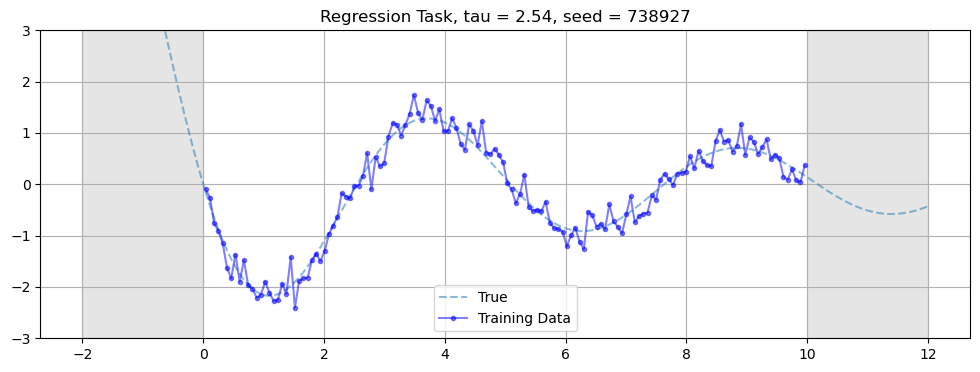

In [27]:
########### Create Folders to store trained data #############
R_FOLDER = 'data/proj1/regression'
if os.path.exists(R_FOLDER):
  shutil.rmtree(R_FOLDER)
os.makedirs(R_FOLDER, exist_ok=True)
# !rm -rf $R_FOLDER # this is not a valid python script, used only in colab
# !mkdir -p $R_FOLDER # this is not a valid python script, used only in colab

###### Constants #####
R_MIN_TEST_X = -2
R_MIN_TRAIN_X = 0
R_MAX_TRAIN_X = 10
R_MAX_TEST_X = 12
R_NUM_POINTS = 200

###### Variables to be initialized later, placed here for clarity ##########
r_model = None
r_expt_name = ''
r_num_hidden = 0
r_learning_rate = 0
r_epochs = 0
r_batch_size = 0
r_elapsed = 0
r_history = None
r_train_indices = None
r_x_test = []
r_y_test = [] # the true y over the domain of x_test
r_x_train = [] # the x data, that has a smaller domain than x_test
r_y_train = [] # the noisy y over the domain of x_train
r_y_pred = [] # to fill in later
r_y_pred_train = []
r_tau = 0

##### Initialize the variables ########
def rInit():
  r_tau = np.random.uniform(2.4, 2.6) if np.random.uniform() > 0.5 else np.random.uniform(3.0, 3.3) # tau is for sinc function
  print(f'tau: {r_tau}')
  r_x_test = np.linspace(R_MIN_TEST_X, R_MAX_TEST_X, R_NUM_POINTS).reshape(-1, 1)
  r_y_test = 10.0*np.sinc((r_x_test + r_tau) / r_tau)
  r_train_indices = (r_x_test >= R_MIN_TRAIN_X) & (r_x_test <= R_MAX_TRAIN_X)
  r_train_indices = np.array(r_train_indices).reshape(-1)
  r_x_train = r_x_test[r_train_indices]
  r_y_train = r_y_test[r_train_indices]
  r_y_train = r_y_train + np.random.normal(0.0, 0.2, r_y_train.shape)
  return r_tau, r_train_indices, r_x_test, r_y_test, r_x_train, r_y_train

##### Plot the Regression Task #######
def rPlotTask():
  fig, ax = plt.subplots()
  ax.axvspan(R_MIN_TEST_X, R_MIN_TRAIN_X, alpha=0.2, color='grey') # out of train domain
  ax.axvspan(R_MAX_TRAIN_X, R_MAX_TEST_X, alpha=0.2, color='grey') # out of train domain
  ax.plot(r_x_test, r_y_test, '--', alpha=0.5, label='True')
  ax.plot(r_x_train, r_y_train, 'b.-', alpha=0.5, label='Training Data')
  ax.grid(True, which='both', axis='both')
  ax.legend();
  ax.set_title(f'Regression Task, tau = {r_tau:.2f}, seed = {SEED}')
  ax.grid(visible=True)
  ax.set_ylim([-3, 3])
  fig.set_size_inches(12.0, 4.0)
  fig.savefig(f'{R_FOLDER}/task.png', dpi=100)

##### Run the functions ##########
makeReproducible() # call this everytime to 'reset' the random number generator and make subsequent random calls reproducible.
r_tau, r_train_indices, r_x_test, r_y_test, r_x_train, r_y_train = rInit()
rPlotTask()

## 2.2 $\quad$ Function that Builds the Regression Model
1. Copy over the code from Lab 1 to build the regression model.

In [28]:
def rBuildModel():
  ###### Specify the layers #####
  # (1)
  input_layer = keras.Input(shape=(1,)) # ?? is tuple specifying the input dimensions.
  hidden_layer = keras.layers.Dense(r_num_hidden, activation='tanh') # ?? is the number of neurons. # ???? is a string specifying the activation function
  output_layer = keras.layers.Dense(1, activation='linear') # ?? is the number of neurons. # ???? is a string specifying the activation function

  ###### Link the layers #####
  # (2)
  output_layer = output_layer(hidden_layer(input_layer))

  ###### Initialize model #####
  # (3)
  r_model = keras.Model(inputs=[input_layer], outputs=[output_layer], name='Regression')

  ###### Compile model #####
  # (4)
  sgd = keras.optimizers.SGD(learning_rate=r_learning_rate)
  r_model.compile(loss=keras.losses.MeanSquaredError(), optimizer=sgd) # ?? is the name of the loss used in regression.

  ###### Summarize #####
  # (5)
  r_model.summary()
  print(f'----------------------------------')
  return r_model

## 2.3 $\quad$ Function that Trains the Regression Model
1. Copy over the code from Lab 1 to train the regression model.

In [29]:
def rTrainModel():
  ########### Train the Model #########
  print(f'    Experiment: {r_expt_name}\nHidden Neurons: {r_num_hidden}\n Learning Rate: {r_learning_rate}\n        Epochs: {r_epochs}\n    Batch Size: {r_batch_size}')
  r_elapsed = time.time()

  # (1)
  r_history = r_model.fit(r_x_train, # the x samples used for training.
                     r_y_train, # the y samples used for training.
                     shuffle=True,
                     batch_size=r_batch_size, # the batch size.
                     epochs=r_epochs, # the number of epochs.
                     validation_split=0,
                     verbose=0,
                     callbacks=[TqdmCallback(verbose=0)],
                     ) # this is a single line-command split over multiple lines for readability.

  r_elapsed = time.time() - r_elapsed

  ########### Save the model ###########
  r_model.save(f'{R_FOLDER}/{r_expt_name}.keras')
  print(f'Trained Model saved to {R_FOLDER}/{r_expt_name}.keras')

  return r_model, r_history, r_elapsed

## 2.4 $\quad$ Function that Predicts using Trained Regression Model
The code is similar to lab 1 but with a different set of requirements.
  1. Find  `r_y_pred` which is the predicted output over the larger test domain $x \in [-2, 12]$. The samples of this domain are stored in `r_x_test`.
  2. Find `r_y_pred_train` which is the predicted output over the domain used for training $x \in [0, 10]$. The samples of this domain are stored in `r_x_train`.

In [30]:
def rPredictModel():
  # (1)
  r_y_pred = r_model.predict(r_x_test)
  # (2)
  r_y_pred_train = r_model.predict(r_x_train)


  return r_y_pred, r_y_pred_train

 17%|█▋        | 837/5000 [00:34<01:54, 36.51epoch/s, loss=0.244]

## 2.5 $\quad$ Function that Analyzes the Trained Regression Model
The code is similar to lab 1 but with a different set of requirements:
  1. Find the test loss `test_loss`, that is the loss between the predicted output `r_y_pred` and the true output `r_y_test`. Both variables are based on the larger testing domain.
  2. Find the train loss `train_loss`, that is the loss between the predicted output `r_y_pred_train` and the measured output `r_y_train`. Both variables are based on the smaller training domain.

In [31]:
######### Analyze ###################
def rAnalyzeModel(): # put in function to prevent temporary vars from polluting the workspace
  ########## Calc loss ##############
  loss = keras.losses.MeanSquaredError()
  # (1)
  test_loss = loss(r_y_test, r_y_pred)
  
  # (2)
  train_loss = loss(r_y_train, r_y_pred_train)

  ########### Plot Predicted output #############
  # Predicted output is over the larger r_x_test data.
  # training is done over the smaller r_x_train data.
  fig, ax = plt.subplots(figsize=(10, 5))
  ax.axvspan(R_MIN_TEST_X, R_MIN_TRAIN_X, alpha=0.2, color='grey') # out of train domain
  ax.axvspan(R_MAX_TRAIN_X, R_MAX_TEST_X, alpha=0.2, color='grey') # out of train domain
  ax.plot(r_x_test, r_y_test, '--', alpha=0.5, label='True')
  ax.plot(r_x_train, r_y_train, 'b.-', alpha=0.5, label='Training Data')
  ax.plot(r_x_test, r_y_pred, color='red', label='Predicted')
  ax.grid(True, which='both', axis='both')
  ax.legend();
  ax.set_title(f'Regression Results ({r_expt_name})')
  ax.grid(visible=True)
  fig.set_size_inches(12.0, 4.0)
  fig.savefig(f'{R_FOLDER}/{r_expt_name}_results.png', dpi=100, bbox_inches='tight')

  ########## Loss Plots #############
  fig, axes = plt.subplots(ncols=2, figsize=(10, 5))
  # MA Loss
  r_history_loss = r_history.history['loss']
  axes[0].plot(r_history_loss)
  axes[0].set_title(f'Moving Average Loss vs. Epoch ({r_expt_name})')
  axes[0].set_ylabel('Moving Average Loss')
  axes[0].set_xlabel('Epoch')
  axes[0].grid(True, which='both', axis='both');
  # Log of MA loss
  axes[1].plot(np.log(r_history_loss))
  axes[1].set_title(f'Log of Moving Average Loss vs. Epoch ({r_expt_name})')
  axes[1].set_ylabel('Log of Moving Average Loss')
  axes[1].set_xlabel('Epoch')
  axes[1].grid(True, which='both', axis='both')
  plt.savefig(f'{R_FOLDER}/{r_expt_name}_loss.png', bbox_inches='tight')

  ########## Find the individual and cumulative contribution of neurons =============
  # Extract weights and simulate responses
  r_l1_weights = r_model.layers[1].get_weights()
  r_l1_w1 = r_l1_weights[0] #w
  r_l1_w0 = r_l1_weights[1] #bias
  # one cell is induced field for each neuron for each sample
  r_y_neuron = np.matmul(r_x_test, r_l1_w1) + r_l1_w0 # Nxnum_hidden
  # activation (output of first layer) of each sample for each neuron
  r_y_neuron = np.tanh(r_y_neuron)

  r_l2_weights = r_model.layers[2].get_weights()
  r_l2_w1 = np.transpose(r_l2_weights[0]) #w (1xnum_hid)
  r_l2_w0 = r_l2_weights[1] #bias
  r_y_neuron = r_y_neuron * r_l2_w1 # Nxnum_hid * 1xnum_hid

  # Show the contribution of each neuron
  fig_nrows = r_num_hidden // 10 + (r_num_hidden % 10 != 0)
  fig, axes = plt.subplots(nrows=fig_nrows, ncols=10, figsize=(20, fig_nrows * 2.0))
  fig.subplots_adjust(top=0.75)
  i = 0
  for ax in fig.axes:
    if i >= r_num_hidden:
      ax.axis('off')
      continue
    ax.plot(r_x_test, r_y_neuron[:, i])
    ax.grid(True, 'both', 'both')
    i += 1
    ax.set_title('$w_{1,%d}y_{%d}$' % (i, i))
  fig.suptitle(f'Individual Contribution of Hidden Neurons ({r_expt_name})', x=0.2, y=0.98)
  plt.savefig(f'{R_FOLDER}/{r_expt_name}_contribution.png', bbox_inches='tight')

  fig, axes = plt.subplots(nrows=fig_nrows, ncols=10, figsize=(20, fig_nrows * 2.3))
  fig.subplots_adjust(top=0.65)
  i = 0
  r_y_neur_cum = np.zeros(r_y_test.shape)
  for ax in fig.axes:
    if i >= r_num_hidden:
      ax.axis('off')
      continue
    r_y_neur_cum[:, 0] += r_y_neuron[:, i]
    ax.plot(r_x_test, r_y_neur_cum)
    ax.grid(True, 'both', 'both')
    i += 1
    ax.set_title('$\sum_{i=1}^{%d} w_{1,i}y_{i}$' % i)
  fig.suptitle(f'Cumulative Contribution of Hidden Neurons ({r_expt_name})', x=0.2, y=0.98)
  plt.savefig(f'{R_FOLDER}/{r_expt_name}_cumulative.png', bbox_inches='tight')

  #### Write to text file ####
  tmp = open(f'{R_FOLDER}/{r_expt_name}.txt', 'w')
  out = ''
  out += f'Experiment\t{r_expt_name}\n'
  out += f'Hidden Neurons\t{r_num_hidden}\n'
  out += f'Learning Rate\t{r_learning_rate}\n'
  out += f'Epochs\t{r_epochs}\n'
  out += f'Batch\t{r_batch_size}\n'
  out += f'Elapsed(s)\t{r_elapsed}\n'
  for i in range(1, 11):
    out += f'Moving Average Loss ({i}0% Epoch)\t{r_history_loss[int(0.1 * i * len(r_history_loss) - 1)]}\n'
  out += f'Train Loss\t{train_loss}\n'
  out += f'Test Loss\t{test_loss}\n'

  out += 'Weights:\n'
  for i in range(r_num_hidden): # first layer
    out += ('w^{(1)}_%d\t%5.2f\t%5.2f\n' % (i + 1, r_l1_w0[i], r_l1_w1[0, i]))
  out += ('w^{(2)}_1\t%5.2f' % r_l2_w0[0])  # output bias
  for i in range(r_num_hidden): # output
    out += '\t%5.2f' % r_l2_w1[0, i]
  out += '\n'

  tmp.write(out)
  tmp.close()
  print(out)

## 2.6 $\quad$ Run the Regression Model

1. Test your code in the same way as Lab 1.
2. Once all errors are fixed, you may adjust the `experiments` list to run multiple experiments and observe the effects of adjusting the hyperparameters.

====================== START OF EXPT Ideal ====================================
Model: "Regression"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_53 (InputLayer)       [(None, 1)]               0         
                                                                 
 dense_104 (Dense)           (None, 8)                 16        
                                                                 
 dense_105 (Dense)           (None, 1)                 9         
                                                                 
Total params: 25
Trainable params: 25
Non-trainable params: 0
_________________________________________________________________
----------------------------------
    Experiment: Ideal
Hidden Neurons: 8
 Learning Rate: 0.025
        Epochs: 7000
    Batch Size: 5


100%|██████████| 7000/7000 [03:20<00:00, 34.95epoch/s, loss=0.0584]


Trained Model saved to data/proj1/regression/Ideal.keras
5/5 [==============================] - 0s 1ms/step
Experiment	Ideal
Hidden Neurons	8
Learning Rate	0.025
Epochs	7000
Batch	5
Elapsed(s)	200.32679104804993
Moving Average Loss (10% Epoch)	0.0926390066742897
Moving Average Loss (20% Epoch)	0.07221875339746475
Moving Average Loss (30% Epoch)	0.058343227952718735
Moving Average Loss (40% Epoch)	0.06089980900287628
Moving Average Loss (50% Epoch)	0.05696245655417442
Moving Average Loss (60% Epoch)	0.05998280271887779
Moving Average Loss (70% Epoch)	0.05949990823864937
Moving Average Loss (80% Epoch)	0.05827309936285019
Moving Average Loss (90% Epoch)	0.05837755650281906
Moving Average Loss (100% Epoch)	0.05841473489999771
Train Loss	0.08408734947443008
Test Loss	1.790739893913269
Weights:
w^{(1)}_1	-0.15	 1.34
w^{(1)}_2	 0.19	 2.34
w^{(1)}_3	 4.33	-0.43
w^{(1)}_4	-2.76	 1.12
w^{(1)}_5	 7.19	-1.46
w^{(1)}_6	 2.02	-0.22
w^{(1)}_7	 3.68	-0.36
w^{(1)}_8	-10.61	 1.41
w^{(2)}_1	 1.18	-1.22	

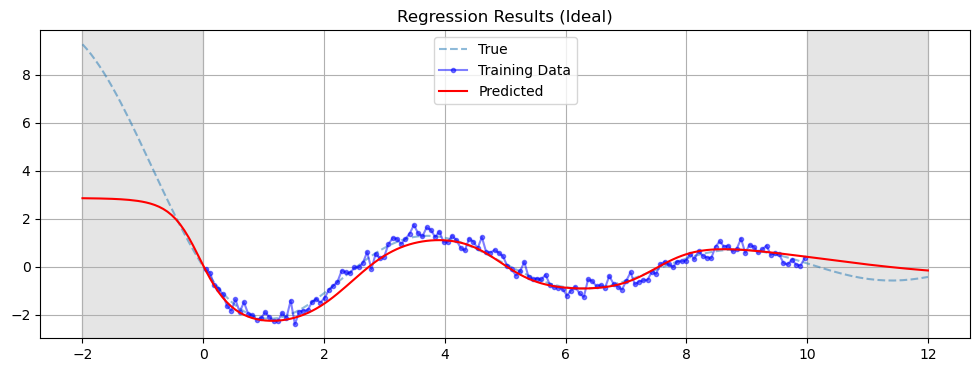

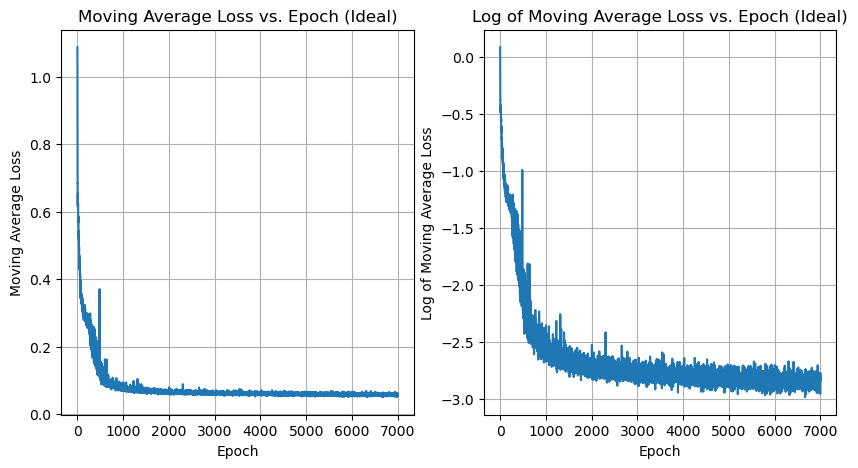

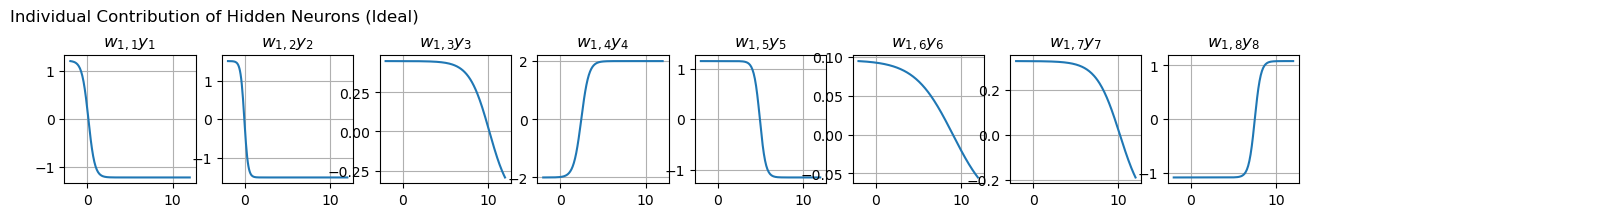

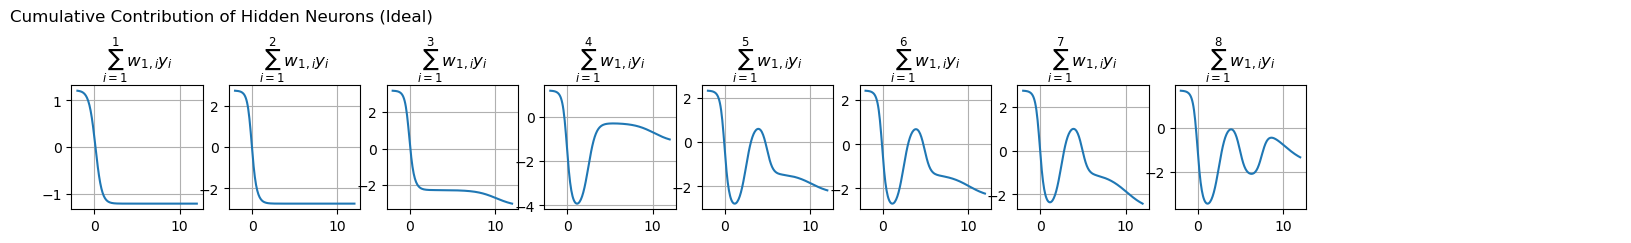

In [34]:
experiments =[
  ('Ideal', 8, 0.025, 7000, 5), # best results used as benchmark model
#   ('Lower Neurons', 4, 0.025, 5000, 5), # lower neurons
#   ('Higher Neurons', 16, 0.025, 5000, 5), # higher neurons
#   ('Lower Learning Rate', 8, 0.001, 5000, 5), # lower learning rate
#   ('Lower Learning Rate acc for more epochs', 8, 0.001, 10000, 5), # lower learning rate and more epochs
#   ('Higher Learning Rate', 8, 0.1, 5000, 5), # higher learning rate
#   ('Lower Epochs', 8, 0.025, 500, 5), # lower epochs
#   ('Higher Epochs', 8, 0.025, 10000, 5), # higher epochs
#   ('Lower Batch Size', 8, 0.025, 5000, 2), # lower batch size # IDT this should be 1 incase of noisy gradients 
#   ('Higher Batch Size', 8, 0.025, 5000, 13), # higher batch size
]

# [H]----- For easy results copying
test_loss_holder = []
train_loss_holder = []
loss = keras.losses.MeanSquaredError()
# [\H]-----

for expt in experiments:
  r_expt_name = expt[0]
  r_num_hidden = expt[1]
  r_learning_rate = expt[2]
  r_epochs = expt[3]
  r_batch_size = expt[4]

  print(f'====================== START OF EXPT {r_expt_name} ====================================')

  makeReproducible()
  r_model = rBuildModel()

  makeReproducible()
  r_model, r_history, r_elapsed = rTrainModel()

  r_y_pred, r_y_pred_train = rPredictModel()
  
    # [H]----- For easy results copying
  # (1) TEST LOSS: Between predicted output r_y_pred and true output r_y_test
  test_loss = loss(r_y_test, r_y_pred)
  # (2) TRAIN LOSS: Between r_y_pred_train and measured output r_y_train
  train_loss = loss(r_y_train, r_y_pred_train)
  test_loss_holder.append(test_loss)
  train_loss_holder.append(train_loss)
  # [\H]-----

  rAnalyzeModel()

  print(f'====================== END OF EXPT {r_expt_name} ======================================')
  
  # [H]----- For easy results copying
print("[H] ----- FINAL LOSS -----")
print("TEST LOSS:")
print(print([t.numpy() for t in test_loss_holder]))
print("TRAIN LOSS:")
print(print([t.numpy() for t in train_loss_holder]))
# [\H]-----

---
3 $\quad$ Classification

In this task, a neural network is built to classify around 42,000 images of 7 randomly chosen digits from the MNIST dataset. Each image is  $28\times28$ pixels in size.
The steps to build a  model for classification is similar to the steps in the regression task.

## 3.1 $\quad$ Classification Initialization
1. Run the following code block once to reset all variables used in the classification task, and preview the chosen digits.


Chosen Digits for MNIST classification:
	[0 1 2 3 4 6 9]
c_x_train Shape (num, dim1, dim2,): (42463, 28, 28)
c_y_train Shape (num,): (42463,)
c_x_test Shape (num, dim1, dim2,): (7106, 28, 28)
c_y_test Shape (num,): (7106,)


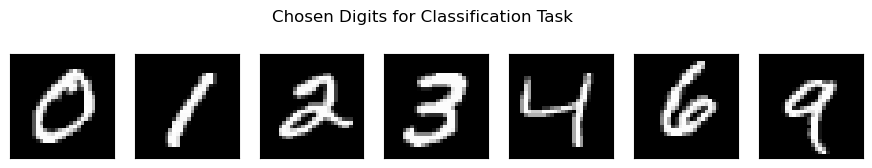

In [12]:
########### Create Folders to store trained data #############
C_FOLDER = 'data/proj1/classification'
shutil.rmtree(C_FOLDER, ignore_errors=True)
os.makedirs(C_FOLDER, exist_ok=True)

###### Constants ############
C_NUM_DIGITS = 7

###### Variables to be initialized later, placed here for clarity ##########
c_model = None
c_expt_name = ''
c_nums_hidden = []
c_learning_rate = 0
c_epochs = 0
c_batch_size = 0
c_elapsed = 0
c_history = None
c_x_train = []
c_y_train = [] # the true y over the domain of x_test
c_x_test = [] # the x data, that has a smaller domain than x_test
c_y_test = [] # the noisy y over the domain of x_train
c_y_train_enc = [] # the noisy y over the domain of x_train
c_y_test_enc = [] # the noisy y over the domain of x_train
c_y_pred_enc = [] # to fill in later
c_y_pred_train_enc = []
c_digits = []
c_layer_flatten = None
c_layer_norm = None

##### Initialize the variables ########
def cInit():
  (c_x_train, c_y_train), (c_x_test, c_y_test) = keras.datasets.mnist.load_data()
  c_digits = np.sort(np.random.choice(np.arange(10), size=C_NUM_DIGITS, replace=False))
  print(f'Chosen Digits for MNIST classification:\n\t{c_digits}')

  selected_train_idx = np.full(shape=c_y_train.shape, fill_value=0, dtype=bool)
  selected_test_idx = np.full(shape=c_y_test.shape, fill_value=0, dtype=bool)
  for digit in c_digits:
    selected_train_idx = selected_train_idx | (c_y_train == digit)
    selected_test_idx = selected_test_idx | (c_y_test == digit)

  # store the chosen images
  c_x_train = c_x_train[selected_train_idx]
  c_y_train = c_y_train[selected_train_idx]
  c_x_test = c_x_test[selected_test_idx]
  c_y_test = c_y_test[selected_test_idx]
  return c_digits, c_x_train, c_y_train, c_x_test, c_y_test

##### Plot the Classification Task #######
def cPlotTask():
  fig, axes = plt.subplots(ncols = C_NUM_DIGITS, nrows=1, figsize=(11,2))
  fig.suptitle('Chosen Digits for Classification Task')
  for i in range(C_NUM_DIGITS):
    digit = c_digits[i]
    axes[i].imshow(c_x_train[np.argmax(c_y_train == digit)], cmap='gray')
    axes[i].set_xticks([])
    axes[i].set_yticks([])

  print(f'c_x_train Shape (num, dim1, dim2,): {c_x_train.shape}')
  print(f'c_y_train Shape (num,): {c_y_train.shape}')
  print(f'c_x_test Shape (num, dim1, dim2,): {c_x_test.shape}')
  print(f'c_y_test Shape (num,): {c_y_test.shape}')


##### Run the functions ##########
makeReproducible() # call this everytime to 'reset' the random number generator and make subsequent random calls reproducible.
c_digits, c_x_train, c_y_train, c_x_test, c_y_test = cInit()
cPlotTask()

## 3.2 $\quad$ Function for Preprocessing Classification Data
Preprocessing is a step that is required for most machine learning tasks. In this project, preprocessing is not required for regression but required for classification. In the classification task, in the function `cPreprocess()`,
  1. Flatten an image input from a $28\times28$ matrix into a $784 \times 1$ feature vector.
  ```python
  c_layer_flatten = keras.layers.Flatten()
  x_train_flat = c_layer_flatten(c_x_train) # obtain a n times 784 vector containing n flatten images, where n is the number of images in the training samples c_x_train.
  ```
  2. Perform unit normalization (0 mean, 1 variance) over every feature for every image in the training dataset, to calculate a total of 784 means and 784 variances.
  ```python
  c_layer_norm = keras.layers.Normalization()
  c_layer_norm.???(x_train_flat) # to calculate and remember every feature's mean and variance in the layer BEFORE training.
  ```
  3. One-hot encode all the labels into an appropriate form for the model to use.
  ```python
  # ??? ensure consecutive labels in the current labels
  layer_enc = keras.layers.CategoryEncoding(C_NUM_DIGITS, output_mode='???') # ??? find the string that is meant for one-hot encoding
  c_y_train_enc = layer_enc(???)
  c_y_test_enc = layer_enc(???)
  ```
  The training and testing labels are stored in `c_y_train` and `c_y_test` respectively. These vectors of labels are $n_{test} \times 1$ and $n_{train} \times 1$ respectively. Each value contained in these vectors is the correct classification of its corresponding training sample (e.g. if the training sample is the digit `3`, then the value in the vector is `3`).
  
  One-hot encoding expects all labels to be consecutive. If $m$ different labels are expected, the values in the vector of labels must be $0,1,2,\cdots,m-1$. In this task, only some digits are chosen, and they may be non-consecutive. Convert the labels in `c_y_train` and `c_y_test` to consecutive values, then use `layer_enc` to one-hot encode the modified labels in `c_y_train` and `c_y_test` to `c_y_train_enc` and `c_y_test_enc` respectively.

The flatten layer `c_layer_flatten`, the normalization layer `c_layer_norm`, and the one-hot encoded values `c_y_train_enc` and `c_y_test_enc` are returned.

In [13]:
def cPreprocess():
  ######## Flatten Layer ########
  # (1)
  c_layer_flatten = keras.layers.Flatten()
  x_train_flatten = c_layer_flatten(c_x_train)

  ######## Normalization Layer ########
  # (2)
  c_layer_norm = keras.layers.Normalization()
  c_layer_norm.adapt(x_train_flatten)

  ######## One-hot encode labels ########
  # (3)
  unique_labels = np.unique(np.concatenate((c_y_train, c_y_test)))   #find unique lables in train and test combined, unqie alrdy sorts
  label_mapping = {}
  for i, label in enumerate(unique_labels):
    label_mapping[label] = i
  c_y_train_mapped = np.vectorize(label_mapping.get)(c_y_train) #use np.vectorize that takes the label_mapping.get function and apply on the c_y_train
  c_y_test_mapped = np.vectorize(label_mapping.get)(c_y_test) 
  
  layer_enc = keras.layers.CategoryEncoding(C_NUM_DIGITS, output_mode='one_hot')
  c_y_train_enc = layer_enc(c_y_train_mapped)
  c_y_test_enc = layer_enc(c_y_test_mapped)

  return c_y_train_enc, c_y_test_enc, c_layer_flatten, c_layer_norm

## 3.3 $\quad$ Function that Builds the Classification Model
1. The code is similar to the regression task, with the following differences:
  - The input shape is $28\times 28$.
  - The number of hidden layers and the number of neurons in each hidden layer is **dynamically generated from** `c_nums_hidden`. `c_nums_hidden` is a list that stores the number of hidden neurons in each hidden layer. If it is `[128]`, there is 1 hidden layer with 128 neurons. If it is `[128,64,32]`, there is 128 neurons in the first hidden layer, 64 neurons in the second hidden layer, and 32 neurons in the third hidden layer.
  - After the input layer is the flatten layer `c_layer_flat`, followed by the normalization layer `c_layer_norm`, and subsequently the hidden layers.
  - There must be the same number of neurons in the output layer as the number of labels. Use `C_NUM_DIGITS`.
  - `c_model` is the model required for the classification task, and is returned by the function.
  - The activation function and the loss for a classification task, are different from the activation function and the loss for a regression task.

In [14]:
def cBuildModel():
  # (1)
  # input layer
  input_layer = keras.Input(shape=(28, 28)) 
  c_layer_flat = c_layer_flatten(input_layer) #note that c_layer_flatten is a global variable that contains the method updated by cPreprocess
  c_layer_normal = c_layer_norm(c_layer_flat) 
  # hidden layers
  hidden_layers = c_layer_normal
  for num_hidden in c_nums_hidden:
    hidden_layers = keras.layers.Dense(num_hidden, activation='relu')(hidden_layers) #iterative so need keep updating hidden_layers
  # output layer
  output_layer = keras.layers.Dense(C_NUM_DIGITS, activation='softmax')(hidden_layers) #output layer
  
  # (2)
  # initialize model
  c_model = keras.Model(inputs=[input_layer], outputs=[output_layer], name='Classification')
  
  # (3)
  # compile model
  sgd = keras.optimizers.SGD(learning_rate=c_learning_rate)
  c_model.compile(loss=keras.losses.CategoricalCrossentropy(), optimizer=sgd)
  
  # (4)
  # summarize model
  c_model.summary()
  
  print(f'----------------------------------')
  return c_model

## 3.4 $\quad$ Function that Trains the Classification Model
1. The code is similar to the regression task, with the following differences:
  - `c_x_train` is the training input
  - `c_y_train_enc` are the one-hot encoded training labels
  - Other relevant hyperparameters prefixed with `c_`

In [15]:
def cTrainModel():
  ########### Train the Model #########
  print(f'    Experiment: {c_expt_name}\nHidden Neurons: {c_nums_hidden}\n Learning Rate: {c_learning_rate}\n        Epochs: {c_epochs}\n    Batch Size: {c_batch_size}')
  c_elapsed = time.time()

  # (1)
  c_history = c_model.fit(c_x_train, 
                     c_y_train_enc, 
                     shuffle=True,
                     batch_size=c_batch_size, 
                     epochs=c_epochs,
                     validation_split=0,
                     verbose=0,
                     callbacks=[TqdmCallback(verbose=0)],
                     ) 

  c_elapsed = time.time() - c_elapsed

  ########### Save the model ###########
  c_model.save(f'{C_FOLDER}/{c_expt_name}.keras')
  print(f'Trained Model saved to {C_FOLDER}/{c_expt_name}.keras')

  return c_model, c_history, c_elapsed

## 3.5 $\quad$ Function that Predicts using Trained Classification Model
The code is similar to the regression task with the following differences:
1. Predict the one-hot encoded output `c_y_pred_enc` from the test images in `c_x_test`.
2. Predict the one-hot encoded output `c_y_pred_train_enc` from the train images in `c_x_train`.

In [16]:
def cPredictModel():
  # (1)
  c_y_pred_enc = c_model.predict(c_x_test)
  # (2)
  c_y_pred_train_enc = c_model.predict(c_x_train)

  return c_y_pred_enc, c_y_pred_train_enc

## 3.6 $\quad$ Function that Analyzes the Trained Classification Model
The function outputs relevant data of the trained model. A metric that is not shown during the training process is *accuracy*, which is the fraction of images that are correctly identified. The metric can be found as follows:
```python
acc = keras.metrics.CategoricalAccuracy()
acc.update_state(??, ????) # ?? contains the one-hot encoded true labels. ???? contains the one-hot encoded predicted labels.
??? = acc.result().numpy() # ??? is the variable that stores the numerical value of the accuracy
```
Using `c_y_test_enc`, `c_y_pred_enc`, `c_y_train_enc`, and `c_y_pred_train_enc`,
1. Find `test_accuracy`, which is the accuracy of the prediction from the test images.
2. Find `train_accuracy`, which is the accuracy of the prediction from the training images

In [17]:
def cAnalyzeModel():
  ##### Find the accuracy of the model ###
  acc = keras.metrics.CategoricalAccuracy()
  # (1)
  acc.update_state(c_y_test_enc, c_y_pred_enc)
  test_accuracy = acc.result().numpy()
  # (2)
  acc.update_state(c_y_train_enc, c_y_pred_train_enc)
  train_accuracy = acc.result().numpy()

  #### Write to text file ####
  c_history_loss = c_history.history['loss']
  tmp = open(f'{C_FOLDER}/{c_expt_name}.txt', 'w')
  out = ''
  out += f'Experiment\t{c_expt_name}\n'
  out += f'Hidden Neurons\t{c_nums_hidden}\n'
  out += f'Learning Rate\t{c_learning_rate}\n'
  out += f'Epochs\t{c_epochs}\n'
  out += f'Batch\t{c_batch_size}\n'
  out += f'Elapsed(s)\t{c_elapsed}\n'
  for i in range(1, 11):
    out += f'Moving Average Loss ({i}0% Epoch)\t{c_history_loss[int(0.1 * i * len(c_history_loss) - 1)]}\n'
  # insert any metric you want to monitor
  out += f'Train Accuracy\t{train_accuracy}\n'
  out += f'Test Accuracy\t{test_accuracy}\n'

  tmp.write(out)
  tmp.close()
  print(out)

## 3.7 $\quad$ Run the Classification Model

1. Test your code in the same way as in the regression task.
2. Once all errors are fixed, you may adjust the `experiments` list to run multiple experiments and observe the effects of adjusting the hyperparameters.

In [18]:
experiments = [
  # ('a', [64], 0.01, 20, 32),
    #Expt Name  # Hidden Neurons    # Learning Rate   # Epoches   # Batch Size
  # ('a',[4],0.01,10,32),
  # ('b',[4],0.01,20,32),
  # ('c',[4],0.01,30,32),
  #one hidden layer
  ('128_0.1',[128],0.1,25,32),
  ('128_0.01',[128],0.01,25,32),
  ('128_0.001',[128],0.001,25,32),

  ('64_0.1',[64],0.1,25,32),
  ('64_0.01',[64],0.01,25,32),
  ('64_0.001',[64],0.001,25,32),

  ('32_0.1',[32],0.1,25,32),
  ('32_0.01',[32],0.01,25,32),
  ('32_0.001',[32],0.001,25,32),
  
  ('16_0.1',[16],0.1,25,32),
  ('16_0.01',[16],0.01,25,32),
  ('16_0.001',[16],0.001,25,32),
  
  ('8_0.1',[8],0.1,25,32),
  ('8_0.01',[8],0.01,25,32),
  ('8_0.001',[8],0.001,25,32),
  
  ('112_0.1',[112],0.1,25,32),
  ('112_0.01',[112],0.01,25,32),
  ('112_0.001',[112],0.001,25,32),
  
  ('56_0.1',[56],0.1,25,32),
  ('56_0.01',[56],0.01,25,32),
  ('56_0.001',[56],0.001,25,32),
  
  ('28_0.1',[28],0.1,25,32),
  ('28_0.01',[28],0.01,25,32),
  ('28_0.001',[28],0.001,25,32),
  
  ('14_0.1',[14],0.1,25,32),
  ('14_0.01',[14],0.01,25,32),
  ('14_0.001',[14],0.001,25,32),
  
  ('7_0.1',[7],0.1,25,32),
  ('7_0.01',[7],0.01,25,32),
  ('7_0.001',[7],0.001,25,32),

]

c_y_train_enc, c_y_test_enc, c_layer_flatten, c_layer_norm = cPreprocess()

for expt in experiments:
  c_expt_name = expt[0]
  c_nums_hidden = expt[1]
  c_learning_rate = expt[2]
  c_epochs = expt[3]
  c_batch_size = expt[4]

  print(f'====================== START OF EXPT {c_expt_name} ====================================')

  makeReproducible()
  c_model = cBuildModel()

  makeReproducible()
  c_model, c_history, c_elapsed = cTrainModel()

  c_y_pred_enc, c_y_pred_train_enc = cPredictModel()

  cAnalyzeModel()

  print(f'====================== END OF EXPT {c_expt_name} ======================================')

====================== START OF EXPT 128_0.1 ====================================
Model: "Classification"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_11 (InputLayer)       [(None, 28, 28)]          0         
                                                                 
 flatten (Flatten)           (None, 784)               0         
                                                                 
 normalization (Normalizatio  (None, 784)              1569      
 n)                                                              
                                                                 
 dense_20 (Dense)            (None, 128)               100480    
                                                                 
 dense_21 (Dense)            (None, 7)                 903       
                                                                 
Total params: 102,952
Trainable para

100%|██████████| 25/25 [00:43<00:00,  1.75s/epoch, loss=0.000509]

Trained Model saved to data/proj1/classification/128_0.1.keras
  1/223 [..............................] - ETA: 18s

1327/1327 [==============================] - 1s 996us/step
Experiment	128_0.1
Hidden Neurons	[128]
Learning Rate	0.1
Epochs	25
Batch	32
Elapsed(s)	43.74393653869629
Moving Average Loss (10% Epoch)	0.1014915481209755
Moving Average Loss (20% Epoch)	0.029938027262687683
Moving Average Loss (30% Epoch)	0.012846875004470348
Moving Average Loss (40% Epoch)	0.003338802605867386
Moving Average Loss (50% Epoch)	0.001977068604901433
Moving Average Loss (60% Epoch)	0.0011707376688718796
Moving Average Loss (70% Epoch)	0.0009239443461410701
Moving Average Loss (80% Epoch)	0.0007100854418240488
Moving Average Loss (90% Epoch)	0.0006115222349762917
Moving Average Loss (100% Epoch)	0.0005086811725050211
Train Accuracy	0.9976598024368286
Test Accuracy	0.9836757779121399

====================== END OF EXPT 128_0.1 ======================================
====================== START OF EXPT 128_0.01 ====================================
Model: "Classification"
____________________________________________

100%|██████████| 25/25 [00:41<00:00,  1.65s/epoch, loss=0.0168]

Trained Model saved to data/proj1/classification/128_0.01.keras
  1/223 [..............................] - ETA: 17s

1327/1327 [==============================] - 1s 1ms/step
Experiment	128_0.01
Hidden Neurons	[128]
Learning Rate	0.01
Epochs	25
Batch	32
Elapsed(s)	41.23233485221863
Moving Average Loss (10% Epoch)	0.1332298070192337
Moving Average Loss (20% Epoch)	0.07657037675380707
Moving Average Loss (30% Epoch)	0.060626644641160965
Moving Average Loss (40% Epoch)	0.0455324612557888
Moving Average Loss (50% Epoch)	0.03851735219359398
Moving Average Loss (60% Epoch)	0.030776962637901306
Moving Average Loss (70% Epoch)	0.026815690100193024
Moving Average Loss (80% Epoch)	0.022219300270080566
Moving Average Loss (90% Epoch)	0.01979331113398075
Moving Average Loss (100% Epoch)	0.01681429333984852
Train Accuracy	0.9950371980667114
Test Accuracy	0.9805797934532166

====================== END OF EXPT 128_0.01 ======================================
====================== START OF EXPT 128_0.001 ====================================
Model: "Classification"
_____________________________________________________

100%|██████████| 25/25 [00:40<00:00,  1.63s/epoch, loss=0.0995]

Trained Model saved to data/proj1/classification/128_0.001.keras
 50/223 [=====>........................] - ETA: 0s 

1327/1327 [==============================] - 1s 1ms/step
Experiment	128_0.001
Hidden Neurons	[128]
Learning Rate	0.001
Epochs	25
Batch	32
Elapsed(s)	40.84975290298462
Moving Average Loss (10% Epoch)	0.34034186601638794
Moving Average Loss (20% Epoch)	0.20278285443782806
Moving Average Loss (30% Epoch)	0.17420479655265808
Moving Average Loss (40% Epoch)	0.1493699848651886
Moving Average Loss (50% Epoch)	0.13823005557060242
Moving Average Loss (60% Epoch)	0.1256476640701294
Moving Average Loss (70% Epoch)	0.11893314868211746
Moving Average Loss (80% Epoch)	0.11052610725164413
Moving Average Loss (90% Epoch)	0.10574599355459213
Moving Average Loss (100% Epoch)	0.09946268051862717
Train Accuracy	0.9709899425506592
Test Accuracy	0.9672108292579651

====================== END OF EXPT 128_0.001 ======================================
====================== START OF EXPT 64_0.1 ====================================
Model: "Classification"
_________________________________________________________

100%|██████████| 25/25 [00:47<00:00,  1.92s/epoch, loss=0.000616]

Trained Model saved to data/proj1/classification/64_0.1.keras
  1/223 [..............................] - ETA: 17s

1327/1327 [==============================] - 2s 1ms/step
Experiment	64_0.1
Hidden Neurons	[64]
Learning Rate	0.1
Epochs	25
Batch	32
Elapsed(s)	48.01725363731384
Moving Average Loss (10% Epoch)	0.10277650505304337
Moving Average Loss (20% Epoch)	0.03879387676715851
Moving Average Loss (30% Epoch)	0.02106226421892643
Moving Average Loss (40% Epoch)	0.0069759744219481945
Moving Average Loss (50% Epoch)	0.0029256956186145544
Moving Average Loss (60% Epoch)	0.001629612292163074
Moving Average Loss (70% Epoch)	0.0012294286862015724
Moving Average Loss (80% Epoch)	0.000889323593582958
Moving Average Loss (90% Epoch)	0.0007524522370658815
Moving Average Loss (100% Epoch)	0.0006164112710393965
Train Accuracy	0.9976396560668945
Test Accuracy	0.9835350513458252

====================== END OF EXPT 64_0.1 ======================================
====================== START OF EXPT 64_0.01 ====================================
Model: "Classification"
___________________________________________________

100%|██████████| 25/25 [00:47<00:00,  1.91s/epoch, loss=0.0202]

Trained Model saved to data/proj1/classification/64_0.01.keras
 23/223 [==>...........................] - ETA: 0s 

1327/1327 [==============================] - 2s 1ms/step
Experiment	64_0.01
Hidden Neurons	[64]
Learning Rate	0.01
Epochs	25
Batch	32
Elapsed(s)	47.78736639022827
Moving Average Loss (10% Epoch)	0.1382979452610016
Moving Average Loss (20% Epoch)	0.08058419823646545
Moving Average Loss (30% Epoch)	0.06494972109794617
Moving Average Loss (40% Epoch)	0.04986196383833885
Moving Average Loss (50% Epoch)	0.042938943952322006
Moving Average Loss (60% Epoch)	0.035031743347644806
Moving Average Loss (70% Epoch)	0.03093622997403145
Moving Average Loss (80% Epoch)	0.026117559522390366
Moving Average Loss (90% Epoch)	0.023489467799663544
Moving Average Loss (100% Epoch)	0.02022557519376278
Train Accuracy	0.9940890669822693
Test Accuracy	0.9804390668869019

====================== END OF EXPT 64_0.01 ======================================
====================== START OF EXPT 64_0.001 ====================================
Model: "Classification"
________________________________________________________

100%|██████████| 25/25 [00:48<00:00,  1.93s/epoch, loss=0.104]

Trained Model saved to data/proj1/classification/64_0.001.keras
 52/223 [=====>........................] - ETA: 0s 

1327/1327 [==============================] - 2s 1ms/step
Experiment	64_0.001
Hidden Neurons	[64]
Learning Rate	0.001
Epochs	25
Batch	32
Elapsed(s)	48.292933225631714
Moving Average Loss (10% Epoch)	0.38259366154670715
Moving Average Loss (20% Epoch)	0.21784855425357819
Moving Average Loss (30% Epoch)	0.18491481244564056
Moving Average Loss (40% Epoch)	0.15756195783615112
Moving Average Loss (50% Epoch)	0.1453201323747635
Moving Average Loss (60% Epoch)	0.13153861463069916
Moving Average Loss (70% Epoch)	0.12424727529287338
Moving Average Loss (80% Epoch)	0.11527474969625473
Moving Average Loss (90% Epoch)	0.11023062467575073
Moving Average Loss (100% Epoch)	0.1036880612373352
Train Accuracy	0.96939617395401
Test Accuracy	0.9634112119674683

====================== END OF EXPT 64_0.001 ======================================
====================== START OF EXPT 32_0.1 ====================================
Model: "Classification"
_____________________________________________________________

100%|██████████| 25/25 [00:47<00:00,  1.91s/epoch, loss=0.000803]

Trained Model saved to data/proj1/classification/32_0.1.keras
 47/223 [=====>........................] - ETA: 0s 

1327/1327 [==============================] - 2s 1ms/step
Experiment	32_0.1
Hidden Neurons	[32]
Learning Rate	0.1
Epochs	25
Batch	32
Elapsed(s)	47.797821283340454
Moving Average Loss (10% Epoch)	0.10173715651035309
Moving Average Loss (20% Epoch)	0.0422823429107666
Moving Average Loss (30% Epoch)	0.026938319206237793
Moving Average Loss (40% Epoch)	0.01008852943778038
Moving Average Loss (50% Epoch)	0.021009236574172974
Moving Average Loss (60% Epoch)	0.007918315008282661
Moving Average Loss (70% Epoch)	0.004723112564533949
Moving Average Loss (80% Epoch)	0.0012732503237202764
Moving Average Loss (90% Epoch)	0.000987828942015767
Moving Average Loss (100% Epoch)	0.0008027635631151497
Train Accuracy	0.9971352815628052
Test Accuracy	0.9802983403205872

====================== END OF EXPT 32_0.1 ======================================
====================== START OF EXPT 32_0.01 ====================================
Model: "Classification"
______________________________________________________

100%|██████████| 25/25 [00:46<00:00,  1.88s/epoch, loss=0.0282]

Trained Model saved to data/proj1/classification/32_0.01.keras
 52/223 [=====>........................] - ETA: 0s 

1327/1327 [==============================] - 1s 1ms/step
Experiment	32_0.01
Hidden Neurons	[32]
Learning Rate	0.01
Epochs	25
Batch	32
Elapsed(s)	46.9486289024353
Moving Average Loss (10% Epoch)	0.14977812767028809
Moving Average Loss (20% Epoch)	0.09004893153905869
Moving Average Loss (30% Epoch)	0.07436497509479523
Moving Average Loss (40% Epoch)	0.059595443308353424
Moving Average Loss (50% Epoch)	0.05264001339673996
Moving Average Loss (60% Epoch)	0.04448631405830383
Moving Average Loss (70% Epoch)	0.0400829017162323
Moving Average Loss (80% Epoch)	0.034892626106739044
Moving Average Loss (90% Epoch)	0.03195992112159729
Moving Average Loss (100% Epoch)	0.028249774128198624
Train Accuracy	0.9916480183601379
Test Accuracy	0.9798761606216431

====================== END OF EXPT 32_0.01 ======================================
====================== START OF EXPT 32_0.001 ====================================
Model: "Classification"
__________________________________________________________

100%|██████████| 25/25 [00:46<00:00,  1.85s/epoch, loss=0.113]

Trained Model saved to data/proj1/classification/32_0.001.keras
  1/223 [..............................] - ETA: 17s

1327/1327 [==============================] - 2s 1ms/step
Experiment	32_0.001
Hidden Neurons	[32]
Learning Rate	0.001
Epochs	25
Batch	32
Elapsed(s)	46.26347327232361
Moving Average Loss (10% Epoch)	0.39584019780158997
Moving Average Loss (20% Epoch)	0.22537045180797577
Moving Average Loss (30% Epoch)	0.19389784336090088
Moving Average Loss (40% Epoch)	0.16721902787685394
Moving Average Loss (50% Epoch)	0.1551189422607422
Moving Average Loss (60% Epoch)	0.14131398499011993
Moving Average Loss (70% Epoch)	0.13406892120838165
Moving Average Loss (80% Epoch)	0.12511758506298065
Moving Average Loss (90% Epoch)	0.12006986141204834
Moving Average Loss (100% Epoch)	0.11348206549882889
Train Accuracy	0.9669349789619446
Test Accuracy	0.9624261260032654

====================== END OF EXPT 32_0.001 ======================================
====================== START OF EXPT 16_0.1 ====================================
Model: "Classification"
___________________________________________________________

100%|██████████| 25/25 [00:43<00:00,  1.75s/epoch, loss=0.0188]

Trained Model saved to data/proj1/classification/16_0.1.keras
 40/223 [====>.........................] - ETA: 0s 

1327/1327 [==============================] - 2s 1ms/step
Experiment	16_0.1
Hidden Neurons	[16]
Learning Rate	0.1
Epochs	25
Batch	32
Elapsed(s)	43.842925786972046
Moving Average Loss (10% Epoch)	0.12796735763549805
Moving Average Loss (20% Epoch)	0.07266860455274582
Moving Average Loss (30% Epoch)	0.055487580597400665
Moving Average Loss (40% Epoch)	0.044328365474939346
Moving Average Loss (50% Epoch)	0.03965979814529419
Moving Average Loss (60% Epoch)	0.032936420291662216
Moving Average Loss (70% Epoch)	0.028802769258618355
Moving Average Loss (80% Epoch)	0.023713374510407448
Moving Average Loss (90% Epoch)	0.020634714514017105
Moving Average Loss (100% Epoch)	0.01882230117917061
Train Accuracy	0.9918497204780579
Test Accuracy	0.9726991057395935

====================== END OF EXPT 16_0.1 ======================================
====================== START OF EXPT 16_0.01 ====================================
Model: "Classification"
________________________________________________________

100%|██████████| 25/25 [00:45<00:00,  1.83s/epoch, loss=0.0519]

Trained Model saved to data/proj1/classification/16_0.01.keras
 14/223 [>.............................] - ETA: 0s 

1327/1327 [==============================] - 1s 1ms/step
Experiment	16_0.01
Hidden Neurons	[16]
Learning Rate	0.01
Epochs	25
Batch	32
Elapsed(s)	45.87138557434082
Moving Average Loss (10% Epoch)	0.16917134821414948
Moving Average Loss (20% Epoch)	0.11248262226581573
Moving Average Loss (30% Epoch)	0.09734666347503662
Moving Average Loss (40% Epoch)	0.08333063125610352
Moving Average Loss (50% Epoch)	0.07660972326993942
Moving Average Loss (60% Epoch)	0.06873936951160431
Moving Average Loss (70% Epoch)	0.06439744681119919
Moving Average Loss (80% Epoch)	0.0590914711356163
Moving Average Loss (90% Epoch)	0.05600142106413841
Moving Average Loss (100% Epoch)	0.05188862979412079
Train Accuracy	0.9833968877792358
Test Accuracy	0.9708696603775024

====================== END OF EXPT 16_0.01 ======================================
====================== START OF EXPT 16_0.001 ====================================
Model: "Classification"
____________________________________________________________

100%|██████████| 25/25 [00:44<00:00,  1.78s/epoch, loss=0.134]

Trained Model saved to data/proj1/classification/16_0.001.keras
 48/223 [=====>........................] - ETA: 0s 

1327/1327 [==============================] - 2s 1ms/step
Experiment	16_0.001
Hidden Neurons	[16]
Learning Rate	0.001
Epochs	25
Batch	32
Elapsed(s)	44.617103815078735
Moving Average Loss (10% Epoch)	0.5063770413398743
Moving Average Loss (20% Epoch)	0.2592679560184479
Moving Average Loss (30% Epoch)	0.21982483565807343
Moving Average Loss (40% Epoch)	0.1889590173959732
Moving Average Loss (50% Epoch)	0.1759984940290451
Moving Average Loss (60% Epoch)	0.16181090474128723
Moving Average Loss (70% Epoch)	0.15451031923294067
Moving Average Loss (80% Epoch)	0.1457320600748062
Moving Average Loss (90% Epoch)	0.14082570374011993
Moving Average Loss (100% Epoch)	0.1344812661409378
Train Accuracy	0.9604793190956116
Test Accuracy	0.9573599696159363

====================== END OF EXPT 16_0.001 ======================================
====================== START OF EXPT 8_0.1 ====================================
Model: "Classification"
________________________________________________________________

100%|██████████| 25/25 [00:44<00:00,  1.77s/epoch, loss=0.0802]

Trained Model saved to data/proj1/classification/8_0.1.keras
 51/223 [=====>........................] - ETA: 0s 

1327/1327 [==============================] - 2s 1ms/step
Experiment	8_0.1
Hidden Neurons	[8]
Learning Rate	0.1
Epochs	25
Batch	32
Elapsed(s)	44.38355565071106
Moving Average Loss (10% Epoch)	0.15766721963882446
Moving Average Loss (20% Epoch)	0.12223580479621887
Moving Average Loss (30% Epoch)	0.10873714834451675
Moving Average Loss (40% Epoch)	0.10114177316427231
Moving Average Loss (50% Epoch)	0.09611701965332031
Moving Average Loss (60% Epoch)	0.09210418164730072
Moving Average Loss (70% Epoch)	0.0871405228972435
Moving Average Loss (80% Epoch)	0.0834471732378006
Moving Average Loss (90% Epoch)	0.08519825339317322
Moving Average Loss (100% Epoch)	0.0801611915230751
Train Accuracy	0.9753475189208984
Test Accuracy	0.9641148447990417

====================== END OF EXPT 8_0.1 ======================================
====================== START OF EXPT 8_0.01 ====================================
Model: "Classification"
_________________________________________________________________
 Lay

100%|██████████| 25/25 [00:44<00:00,  1.79s/epoch, loss=0.0942]

Trained Model saved to data/proj1/classification/8_0.01.keras
 52/223 [=====>........................] - ETA: 0s 

1327/1327 [==============================] - 2s 1ms/step
Experiment	8_0.01
Hidden Neurons	[8]
Learning Rate	0.01
Epochs	25
Batch	32
Elapsed(s)	44.91516876220703
Moving Average Loss (10% Epoch)	0.19094982743263245
Moving Average Loss (20% Epoch)	0.1392991989850998
Moving Average Loss (30% Epoch)	0.12809276580810547
Moving Average Loss (40% Epoch)	0.11765599250793457
Moving Average Loss (50% Epoch)	0.1129101887345314
Moving Average Loss (60% Epoch)	0.10739362984895706
Moving Average Loss (70% Epoch)	0.10390916466712952
Moving Average Loss (80% Epoch)	0.09994113445281982
Moving Average Loss (90% Epoch)	0.09754849225282669
Moving Average Loss (100% Epoch)	0.0942169651389122
Train Accuracy	0.9717565178871155
Test Accuracy	0.9614410400390625

====================== END OF EXPT 8_0.01 ======================================
====================== START OF EXPT 8_0.001 ====================================
Model: "Classification"
_________________________________________________________________


100%|██████████| 25/25 [00:45<00:00,  1.80s/epoch, loss=0.155]

Trained Model saved to data/proj1/classification/8_0.001.keras
 50/223 [=====>........................] - ETA: 0s 

1327/1327 [==============================] - 2s 1ms/step
Experiment	8_0.001
Hidden Neurons	[8]
Learning Rate	0.001
Epochs	25
Batch	32
Elapsed(s)	45.176239252090454
Moving Average Loss (10% Epoch)	0.8715918064117432
Moving Average Loss (20% Epoch)	0.37168005108833313
Moving Average Loss (30% Epoch)	0.27373597025871277
Moving Average Loss (40% Epoch)	0.21849893033504486
Moving Average Loss (50% Epoch)	0.2002064436674118
Moving Average Loss (60% Epoch)	0.18322968482971191
Moving Average Loss (70% Epoch)	0.1752961128950119
Moving Average Loss (80% Epoch)	0.16618050634860992
Moving Average Loss (90% Epoch)	0.16135290265083313
Moving Average Loss (100% Epoch)	0.15547947585582733
Train Accuracy	0.9551534056663513
Test Accuracy	0.954686164855957

====================== END OF EXPT 8_0.001 ======================================
====================== START OF EXPT 112_0.1 ====================================
Model: "Classification"
_______________________________________________________________

100%|██████████| 25/25 [00:45<00:00,  1.80s/epoch, loss=0.000535]

Trained Model saved to data/proj1/classification/112_0.1.keras
 50/223 [=====>........................] - ETA: 0s 

1327/1327 [==============================] - 1s 1ms/step
Experiment	112_0.1
Hidden Neurons	[112]
Learning Rate	0.1
Epochs	25
Batch	32
Elapsed(s)	45.14121985435486
Moving Average Loss (10% Epoch)	0.11732985824346542
Moving Average Loss (20% Epoch)	0.02433539740741253
Moving Average Loss (30% Epoch)	0.011280333623290062
Moving Average Loss (40% Epoch)	0.0033203489147126675
Moving Average Loss (50% Epoch)	0.0019696068484336138
Moving Average Loss (60% Epoch)	0.0012175029842182994
Moving Average Loss (70% Epoch)	0.0009746983414515853
Moving Average Loss (80% Epoch)	0.0007448921096511185
Moving Average Loss (90% Epoch)	0.0006395679083652794
Moving Average Loss (100% Epoch)	0.0005353223532438278
Train Accuracy	0.9975388050079346
Test Accuracy	0.9828314185142517

====================== END OF EXPT 112_0.1 ======================================
====================== START OF EXPT 112_0.01 ====================================
Model: "Classification"
____________________________________________

100%|██████████| 25/25 [00:45<00:00,  1.82s/epoch, loss=0.0172]

Trained Model saved to data/proj1/classification/112_0.01.keras
 42/223 [====>.........................] - ETA: 0s 

1327/1327 [==============================] - 2s 1ms/step
Experiment	112_0.01
Hidden Neurons	[112]
Learning Rate	0.01
Epochs	25
Batch	32
Elapsed(s)	45.4397931098938
Moving Average Loss (10% Epoch)	0.13162730634212494
Moving Average Loss (20% Epoch)	0.07664743810892105
Moving Average Loss (30% Epoch)	0.0610799677670002
Moving Average Loss (40% Epoch)	0.04587700217962265
Moving Average Loss (50% Epoch)	0.03881900757551193
Moving Average Loss (60% Epoch)	0.031149685382843018
Moving Average Loss (70% Epoch)	0.02724464237689972
Moving Average Loss (80% Epoch)	0.02266691066324711
Moving Average Loss (90% Epoch)	0.020217759534716606
Moving Average Loss (100% Epoch)	0.017221840098500252
Train Accuracy	0.9947951436042786
Test Accuracy	0.9793132543563843

====================== END OF EXPT 112_0.01 ======================================
====================== START OF EXPT 112_0.001 ====================================
Model: "Classification"
______________________________________________________

100%|██████████| 25/25 [00:44<00:00,  1.79s/epoch, loss=0.0985]

Trained Model saved to data/proj1/classification/112_0.001.keras
 37/223 [===>..........................] - ETA: 0s 

1327/1327 [==============================] - 2s 1ms/step
Experiment	112_0.001
Hidden Neurons	[112]
Learning Rate	0.001
Epochs	25
Batch	32
Elapsed(s)	44.81879472732544
Moving Average Loss (10% Epoch)	0.3394313454627991
Moving Average Loss (20% Epoch)	0.201809361577034
Moving Average Loss (30% Epoch)	0.17232447862625122
Moving Average Loss (40% Epoch)	0.1471530795097351
Moving Average Loss (50% Epoch)	0.1361013650894165
Moving Average Loss (60% Epoch)	0.12374471127986908
Moving Average Loss (70% Epoch)	0.11721549928188324
Moving Average Loss (80% Epoch)	0.10912037640810013
Moving Average Loss (90% Epoch)	0.10453440248966217
Moving Average Loss (100% Epoch)	0.09852426499128342
Train Accuracy	0.9709697365760803
Test Accuracy	0.9662257432937622

====================== END OF EXPT 112_0.001 ======================================
====================== START OF EXPT 56_0.1 ====================================
Model: "Classification"
____________________________________________________________

100%|██████████| 25/25 [00:56<00:00,  2.24s/epoch, loss=0.000641]

Trained Model saved to data/proj1/classification/56_0.1.keras
 50/223 [=====>........................] - ETA: 0s 

1327/1327 [==============================] - 2s 1ms/step
Experiment	56_0.1
Hidden Neurons	[56]
Learning Rate	0.1
Epochs	25
Batch	32
Elapsed(s)	56.07582139968872
Moving Average Loss (10% Epoch)	0.10746358335018158
Moving Average Loss (20% Epoch)	0.036898404359817505
Moving Average Loss (30% Epoch)	0.014895903877913952
Moving Average Loss (40% Epoch)	0.005047349259257317
Moving Average Loss (50% Epoch)	0.0029262229800224304
Moving Average Loss (60% Epoch)	0.0015683113597333431
Moving Average Loss (70% Epoch)	0.001225592684932053
Moving Average Loss (80% Epoch)	0.0009119448950514197
Moving Average Loss (90% Epoch)	0.0007675880915485322
Moving Average Loss (100% Epoch)	0.000641047430690378
Train Accuracy	0.997256338596344
Test Accuracy	0.980861246585846

====================== END OF EXPT 56_0.1 ======================================
====================== START OF EXPT 56_0.01 ====================================
Model: "Classification"
____________________________________________________

100%|██████████| 25/25 [00:53<00:00,  2.15s/epoch, loss=0.0212]

Trained Model saved to data/proj1/classification/56_0.01.keras
  1/223 [..............................] - ETA: 17s

1327/1327 [==============================] - 2s 1ms/step
Experiment	56_0.01
Hidden Neurons	[56]
Learning Rate	0.01
Epochs	25
Batch	32
Elapsed(s)	53.754170656204224
Moving Average Loss (10% Epoch)	0.1385524719953537
Moving Average Loss (20% Epoch)	0.08059799671173096
Moving Average Loss (30% Epoch)	0.06511922925710678
Moving Average Loss (40% Epoch)	0.05037648603320122
Moving Average Loss (50% Epoch)	0.043539293110370636
Moving Average Loss (60% Epoch)	0.03581303730607033
Moving Average Loss (70% Epoch)	0.03186682239174843
Moving Average Loss (80% Epoch)	0.02711155079305172
Moving Average Loss (90% Epoch)	0.02451408840715885
Moving Average Loss (100% Epoch)	0.02124819904565811
Train Accuracy	0.9936452507972717
Test Accuracy	0.9810019731521606

====================== END OF EXPT 56_0.01 ======================================
====================== START OF EXPT 56_0.001 ====================================
Model: "Classification"
__________________________________________________________

100%|██████████| 25/25 [00:49<00:00,  2.00s/epoch, loss=0.104]

Trained Model saved to data/proj1/classification/56_0.001.keras
 52/223 [=====>........................] - ETA: 0s 

1327/1327 [==============================] - 2s 1ms/step
Experiment	56_0.001
Hidden Neurons	[56]
Learning Rate	0.001
Epochs	25
Batch	32
Elapsed(s)	49.94730877876282
Moving Average Loss (10% Epoch)	0.3782885670661926
Moving Average Loss (20% Epoch)	0.2147168517112732
Moving Average Loss (30% Epoch)	0.1833326667547226
Moving Average Loss (40% Epoch)	0.15687806904315948
Moving Average Loss (50% Epoch)	0.1450250893831253
Moving Average Loss (60% Epoch)	0.13155408203601837
Moving Average Loss (70% Epoch)	0.1244724839925766
Moving Average Loss (80% Epoch)	0.11564664542675018
Moving Average Loss (90% Epoch)	0.11059992760419846
Moving Average Loss (100% Epoch)	0.10409458726644516
Train Accuracy	0.9693760275840759
Test Accuracy	0.9660850167274475

====================== END OF EXPT 56_0.001 ======================================
====================== START OF EXPT 28_0.1 ====================================
Model: "Classification"
_______________________________________________________________

100%|██████████| 25/25 [00:44<00:00,  1.77s/epoch, loss=0.00112]

Trained Model saved to data/proj1/classification/28_0.1.keras
 50/223 [=====>........................] - ETA: 0s 

1327/1327 [==============================] - 2s 1ms/step
Experiment	28_0.1
Hidden Neurons	[28]
Learning Rate	0.1
Epochs	25
Batch	32
Elapsed(s)	44.33003640174866
Moving Average Loss (10% Epoch)	0.1139121726155281
Moving Average Loss (20% Epoch)	0.0394560880959034
Moving Average Loss (30% Epoch)	0.02855071984231472
Moving Average Loss (40% Epoch)	0.017162026837468147
Moving Average Loss (50% Epoch)	0.013315083459019661
Moving Average Loss (60% Epoch)	0.005916888359934092
Moving Average Loss (70% Epoch)	0.002814088948071003
Moving Average Loss (80% Epoch)	0.0019003428751602769
Moving Average Loss (90% Epoch)	0.0014499053359031677
Moving Average Loss (100% Epoch)	0.001115045277401805
Train Accuracy	0.9970344305038452
Test Accuracy	0.9797354340553284

====================== END OF EXPT 28_0.1 ======================================
====================== START OF EXPT 28_0.01 ====================================
Model: "Classification"
________________________________________________________

100%|██████████| 25/25 [00:45<00:00,  1.83s/epoch, loss=0.0293]

Trained Model saved to data/proj1/classification/28_0.01.keras
 45/223 [=====>........................] - ETA: 0s 

1327/1327 [==============================] - 2s 1ms/step
Experiment	28_0.01
Hidden Neurons	[28]
Learning Rate	0.01
Epochs	25
Batch	32
Elapsed(s)	45.91539549827576
Moving Average Loss (10% Epoch)	0.14863815903663635
Moving Average Loss (20% Epoch)	0.09128037840127945
Moving Average Loss (30% Epoch)	0.0755714699625969
Moving Average Loss (40% Epoch)	0.060551967471838
Moving Average Loss (50% Epoch)	0.05334118753671646
Moving Average Loss (60% Epoch)	0.04515510052442551
Moving Average Loss (70% Epoch)	0.04087794944643974
Moving Average Loss (80% Epoch)	0.035841409116983414
Moving Average Loss (90% Epoch)	0.0328645221889019
Moving Average Loss (100% Epoch)	0.029293494299054146
Train Accuracy	0.9913655519485474
Test Accuracy	0.9774838089942932

====================== END OF EXPT 28_0.01 ======================================
====================== START OF EXPT 28_0.001 ====================================
Model: "Classification"
_____________________________________________________________

100%|██████████| 25/25 [00:45<00:00,  1.82s/epoch, loss=0.114]

Trained Model saved to data/proj1/classification/28_0.001.keras
  1/223 [..............................] - ETA: 18s

1327/1327 [==============================] - 2s 1ms/step
Experiment	28_0.001
Hidden Neurons	[28]
Learning Rate	0.001
Epochs	25
Batch	32
Elapsed(s)	45.52232527732849
Moving Average Loss (10% Epoch)	0.418582558631897
Moving Average Loss (20% Epoch)	0.22948050498962402
Moving Average Loss (30% Epoch)	0.19569942355155945
Moving Average Loss (40% Epoch)	0.16756847500801086
Moving Average Loss (50% Epoch)	0.15513527393341064
Moving Average Loss (60% Epoch)	0.14142023026943207
Moving Average Loss (70% Epoch)	0.13427434861660004
Moving Average Loss (80% Epoch)	0.12541551887989044
Moving Average Loss (90% Epoch)	0.12038542330265045
Moving Average Loss (100% Epoch)	0.11389728635549545
Train Accuracy	0.9663701057434082
Test Accuracy	0.9628483057022095

====================== END OF EXPT 28_0.001 ======================================
====================== START OF EXPT 14_0.1 ====================================
Model: "Classification"
____________________________________________________________

100%|██████████| 25/25 [00:44<00:00,  1.77s/epoch, loss=0.0312]

Trained Model saved to data/proj1/classification/14_0.1.keras
  1/223 [..............................] - ETA: 17s

1327/1327 [==============================] - 2s 1ms/step
Experiment	14_0.1
Hidden Neurons	[14]
Learning Rate	0.1
Epochs	25
Batch	32
Elapsed(s)	44.410308599472046
Moving Average Loss (10% Epoch)	0.1294483244419098
Moving Average Loss (20% Epoch)	0.08805527538061142
Moving Average Loss (30% Epoch)	0.08256052434444427
Moving Average Loss (40% Epoch)	0.05750209838151932
Moving Average Loss (50% Epoch)	0.05015065148472786
Moving Average Loss (60% Epoch)	0.045346904546022415
Moving Average Loss (70% Epoch)	0.04275568574666977
Moving Average Loss (80% Epoch)	0.037590574473142624
Moving Average Loss (90% Epoch)	0.04326052963733673
Moving Average Loss (100% Epoch)	0.03118077665567398
Train Accuracy	0.9878553152084351
Test Accuracy	0.9677737355232239

====================== END OF EXPT 14_0.1 ======================================
====================== START OF EXPT 14_0.01 ====================================
Model: "Classification"
_____________________________________________________________

100%|██████████| 25/25 [00:45<00:00,  1.82s/epoch, loss=0.0576]

Trained Model saved to data/proj1/classification/14_0.01.keras
  1/223 [..............................] - ETA: 17s

1327/1327 [==============================] - 2s 1ms/step
Experiment	14_0.01
Hidden Neurons	[14]
Learning Rate	0.01
Epochs	25
Batch	32
Elapsed(s)	45.464287996292114
Moving Average Loss (10% Epoch)	0.17497305572032928
Moving Average Loss (20% Epoch)	0.12007629871368408
Moving Average Loss (30% Epoch)	0.10535133630037308
Moving Average Loss (40% Epoch)	0.09067966043949127
Moving Average Loss (50% Epoch)	0.08343452215194702
Moving Average Loss (60% Epoch)	0.07526469975709915
Moving Average Loss (70% Epoch)	0.07070454210042953
Moving Average Loss (80% Epoch)	0.06515691429376602
Moving Average Loss (90% Epoch)	0.06185702234506607
Moving Average Loss (100% Epoch)	0.057607654482126236
Train Accuracy	0.9826101064682007
Test Accuracy	0.9704474806785583

====================== END OF EXPT 14_0.01 ======================================
====================== START OF EXPT 14_0.001 ====================================
Model: "Classification"
_________________________________________________________

100%|██████████| 25/25 [00:45<00:00,  1.83s/epoch, loss=0.139]

Trained Model saved to data/proj1/classification/14_0.001.keras
 33/223 [===>..........................] - ETA: 0s 

1327/1327 [==============================] - 2s 1ms/step
Experiment	14_0.001
Hidden Neurons	[14]
Learning Rate	0.001
Epochs	25
Batch	32
Elapsed(s)	45.86874556541443
Moving Average Loss (10% Epoch)	0.4956534206867218
Moving Average Loss (20% Epoch)	0.2611995041370392
Moving Average Loss (30% Epoch)	0.22299335896968842
Moving Average Loss (40% Epoch)	0.19286592304706573
Moving Average Loss (50% Epoch)	0.18007051944732666
Moving Average Loss (60% Epoch)	0.16608040034770966
Moving Average Loss (70% Epoch)	0.15893863141536713
Moving Average Loss (80% Epoch)	0.1503007858991623
Moving Average Loss (90% Epoch)	0.1455371379852295
Moving Average Loss (100% Epoch)	0.13948288559913635
Train Accuracy	0.9596320390701294
Test Accuracy	0.9572192430496216

====================== END OF EXPT 14_0.001 ======================================
====================== START OF EXPT 7_0.1 ====================================
Model: "Classification"
_______________________________________________________________

100%|██████████| 25/25 [00:44<00:00,  1.77s/epoch, loss=0.0889]

Trained Model saved to data/proj1/classification/7_0.1.keras
 47/223 [=====>........................] - ETA: 0s 

1327/1327 [==============================] - 2s 1ms/step
Experiment	7_0.1
Hidden Neurons	[7]
Learning Rate	0.1
Epochs	25
Batch	32
Elapsed(s)	44.35146117210388
Moving Average Loss (10% Epoch)	0.1661238670349121
Moving Average Loss (20% Epoch)	0.12026230245828629
Moving Average Loss (30% Epoch)	0.11319892853498459
Moving Average Loss (40% Epoch)	0.1080847829580307
Moving Average Loss (50% Epoch)	0.1027723178267479
Moving Average Loss (60% Epoch)	0.09795692563056946
Moving Average Loss (70% Epoch)	0.09817720949649811
Moving Average Loss (80% Epoch)	0.09127715229988098
Moving Average Loss (90% Epoch)	0.09188124537467957
Moving Average Loss (100% Epoch)	0.08893290907144547
Train Accuracy	0.9743791222572327
Test Accuracy	0.9610188603401184

====================== END OF EXPT 7_0.1 ======================================
====================== START OF EXPT 7_0.01 ====================================
Model: "Classification"
_________________________________________________________________
 Lay

100%|██████████| 25/25 [00:44<00:00,  1.76s/epoch, loss=0.0966]

Trained Model saved to data/proj1/classification/7_0.01.keras
 25/223 [==>...........................] - ETA: 0s 

1327/1327 [==============================] - 2s 1ms/step
Experiment	7_0.01
Hidden Neurons	[7]
Learning Rate	0.01
Epochs	25
Batch	32
Elapsed(s)	44.06897711753845
Moving Average Loss (10% Epoch)	0.21633794903755188
Moving Average Loss (20% Epoch)	0.14522409439086914
Moving Average Loss (30% Epoch)	0.13214407861232758
Moving Average Loss (40% Epoch)	0.1203676089644432
Moving Average Loss (50% Epoch)	0.11493006348609924
Moving Average Loss (60% Epoch)	0.10902592539787292
Moving Average Loss (70% Epoch)	0.10584328323602676
Moving Average Loss (80% Epoch)	0.10205518454313278
Moving Average Loss (90% Epoch)	0.0995187982916832
Moving Average Loss (100% Epoch)	0.0966314971446991
Train Accuracy	0.9712925553321838
Test Accuracy	0.9624261260032654

====================== END OF EXPT 7_0.01 ======================================
====================== START OF EXPT 7_0.001 ====================================
Model: "Classification"
_________________________________________________________________


100%|██████████| 25/25 [00:44<00:00,  1.80s/epoch, loss=0.184]

Trained Model saved to data/proj1/classification/7_0.001.keras
  1/223 [..............................] - ETA: 17s

1327/1327 [==============================] - 2s 1ms/step
Experiment	7_0.001
Hidden Neurons	[7]
Learning Rate	0.001
Epochs	25
Batch	32
Elapsed(s)	45.023104429244995
Moving Average Loss (10% Epoch)	0.9106099605560303
Moving Average Loss (20% Epoch)	0.38008004426956177
Moving Average Loss (30% Epoch)	0.3098011314868927
Moving Average Loss (40% Epoch)	0.2617596983909607
Moving Average Loss (50% Epoch)	0.24301253259181976
Moving Average Loss (60% Epoch)	0.22302596271038055
Moving Average Loss (70% Epoch)	0.21275721490383148
Moving Average Loss (80% Epoch)	0.19999706745147705
Moving Average Loss (90% Epoch)	0.19295725226402283
Moving Average Loss (100% Epoch)	0.1838705837726593
Train Accuracy	0.9482942819595337
Test Accuracy	0.9483535289764404

====================== END OF EXPT 7_0.001 ======================================


---
# 4 $\quad$ Download Data
Run the following code to download all figures and data, which can be used in the report.

In [19]:
# !rm -rf data.zip
# !zip -r data.zip data
#zip data folder and download with os
shutil.make_archive('data', 'zip', 'data')

'c:\\Users\\johna\\Desktop\\EE4312\\data.zip'

---
# 5 $\quad$ Submission Requirements
1. Complete all the code.

2. For the regression task, explain in the report, the discrepancy between the predicted output and the true output outside of the training domain.

3. For both the regression and classification tasks, investigate the effects of changing the hyperparameters by observing the results of about 10 well-designed experiments for each task. The effects of adjusting a hyperparameter can be more reasonably inferred if the other hyperparameters are fixed and well-represented. Subsequently, summarize the effects as clearly and concisely as possible in the report by combining the observations from both tasks. Keep in mind any limiting factors that may affect the results. The number of epochs should not exceed 10,000 and 50 for the regression and classification task respectively.

4. For both the regression and classification tasks, propose an effective and generalizable way to improve the loss over the training domain. Non-exhaustive ways to improve the loss are to adjust the initial starting weights, momentum, regularization, or implementing an adaptable learning rate. The improvement must be verified by a suffient number of experiments.

5. **Do not indicate your name anywhere in this file (P1C) and the report (P1R)**.

6. Rename this file as `P1_<team>.ipynb` where `<team>` is your 2-digit team number. For example, `P1_03.ipynb` for team 3, and submit to Canvas `P1C` assignment. Only one team member needs to submit.

7. The report should be named similarly as `P1_<team>.pdf`, and submit to Canvas `P1R` assignment. Only one team member needs to submit, and if corrections are made, make sure the same member re-submits the file to avoid high plagiarism count on Turnitin.  

8. Record a 7-min presentation, named similarly as `P1_<team>.mp4`, and submit to Canvas `P1C` assignment. Additional instructions to submit to Panopto is in the Canvas assignment. Only one member needs to submit. The video should include a 6-min recorded presentation and 1-min fast-forwarded recording of this worksheet being run. When demonstrating, only one experiment from each task has to be shown, and this experiment can be based on the improvement in (4).


1. Choose the best experiments that show the impacts of the hyperparameters tunning